# Exploring Delahaye mQTLs: Replication, Cleaning, and Enrichment
Goals:
1. Load in data and assess replication between Placental Regulation (Delahaye) dataset, RICHS, and Placental data from the Robinson Lab
1. Assess effect of genotype dosage on number of significant mQTLs, repeating for sex-stratified dosage filters
1. Assess hits that stand-up to "fine mapping"
1. Assess effect sizes of sex-specific hits in terms of differences in allelic fold-change (aFC)
1. Categorize hits based on their position relative to CpG islands and chromosome position

In [5]:
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

Matplotlib created a temporary config/cache directory at /tmp/pbs.2123612.pbsha.ib.sockeye/matplotlib-vbie1iju because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


## Replication assessment
### Loading in marginal data 
This is slightly faster in python, I have saved large datasets as a parquet file, which can be read using `pandas` and `pyarrow` in python, and the `arrow` library in R.

In [2]:
%%time
delahaye = dd.read_parquet("../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet")

CPU times: user 17 ms, sys: 14.7 ms, total: 31.7 ms
Wall time: 300 ms


Just checking that enrichment is what I would expect for cis-mQTL analysis (mostly uniform other than many hits due to enrichment of signal in *cis*).

CPU times: user 3min, sys: 30.3 s, total: 3min 30s
Wall time: 2min 39s


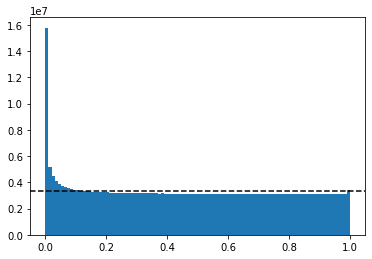

In [3]:
%%time
hist, bins = da.histogram(delahaye['p-value'],bins=100, range=[0,1])
hist = hist.compute()
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
plt.bar(x, hist, width);
plt.axhline(y=hist.sum() / 100.0, linestyle='--', color='black')

Loading in remaining data:

In [3]:
richs = dd.read_parquet("../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet")
robinson = dd.read_parquet("../../robinson_results/cis_impute_mQTL_results_6_methy_PC.parquet")

### Replication of marginal signals

In [16]:
%%time
def run_replication(df1,df2):
    return df2.merge(df1, on=['SNP','gene'])

# Make data frame of hits and then filter for parallel merge
richs_hits = richs[richs['FDR'] < 0.05].compute()
robinson_hits =robinson[robinson['FDR'] < 0.05].compute()
delahaye_hits = delahaye[delahaye['FDR'] < 0.05].compute()

# Retrieve hits pvalues in df2 corresponding to hits in df1
delahaye_richs = run_replication(delahaye_hits, richs)
richs_delahaye = run_replication(richs_hits, delahaye)
delahaye_robinson = run_replication(delahaye_hits, robinson)
robinson_delahaye = run_replication(robinson_hits,delahaye)

CPU times: user 5min 27s, sys: 57.1 s, total: 6min 24s
Wall time: 5min 9s


In [7]:
delahaye_richs_p = delahaye_richs['p-value_x'].compute()
richs_delahaye_p = richs_delahaye['p-value_x'].compute()
delahaye_robinson_p = delahaye_robinson['p-value_x'].compute()
robinson_delahaye_p = robinson_delahaye['p-value_x'].compute()

In [8]:
%%R -i delahaye_richs_p,richs_delahaye_p,delahaye_robinson_p,robinson_delahaye_p
library(qvalue)
print(1 - pi0est(na.omit(delahaye_richs_p))$pi0)
print(1 - pi0est(na.omit(richs_delahaye_p))$pi0)
print(1 - pi0est(na.omit(delahaye_robinson_p))$pi0)
print(1 - pi0est(na.omit(robinson_delahaye_p))$pi0)

  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



[1] 0.7401157
[1] 0.8158023
[1] 0.726035
[1] 0.8115302


### Loading in sex-specific signals

In [4]:
delahaye_sex = dd.read_parquet("../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet")
richs_sex = dd.read_parquet("../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet")
robinson_sex = dd.read_parquet("../../robinson_results/cis_int_sex_impute_mQTL_results_6_methy_PC.parquet")

The number of overlapping hits is fairly small so the $\pi_1$ metric will not be very useful. Instead I'll just assess overlap in hits:

In [28]:
%%time 
# Make data frame of hits and then filter for parallel merge
richs_hits_sex = richs_sex[richs_sex['FDR'] < 0.05].compute()
robinson_hits_sex =robinson_sex[robinson_sex['FDR'] < 0.05].compute()
delahaye_hits_sex = delahaye_sex[delahaye_sex['FDR'] < 0.05].compute()

delahaye_richs_sex = run_replication(delahaye_hits_sex, richs_sex).compute()
richs_delahaye_sex = run_replication(richs_hits_sex, delahaye_sex).compute()
delahaye_robinson_sex = run_replication(delahaye_hits_sex, robinson_sex).compute()
robinson_delahaye_sex = run_replication(robinson_hits_sex, delahaye_sex).compute()

print(len(delahaye_richs_sex))
print(len(richs_delahaye_sex))
print(len(delahaye_robinson_sex))
print(len(robinson_delahaye_sex))

80363
53204
12922
21225
CPU times: user 13min 58s, sys: 2min 14s, total: 16min 12s
Wall time: 9min 59s


The number of CpG sites with at least one sb-mQTL:

In [31]:
print(len(delahaye_richs_sex['gene'].unique()))
print(len(richs_delahaye_sex['gene'].unique()))
print(len(delahaye_robinson_sex['gene'].unique()))
print(len(robinson_delahaye_sex['gene'].unique()))

20874
11275
3204
3998


## Effect of genotype dosage on number of mQTLs in Delahaye data
### Marginal
#### Loading in required data
**Required data:**
* Minor allele frequencies (`.afreq` file)
* Marginal hits (computed on dask dataframe)


In [5]:
delahaye_maf = pd.read_csv("../../delahaye_QC/placenta_regulatory_landscape/RootStudyConsentSet_phs001717.PlacentalRegulation.v1.p1.c1.HMB-IRB-PUB-COL-MDS/genotype_qc/all_imputed_r2_30_rsid.afreq",sep='\s+')
if not "delahaye_hits" in vars():
    delahaye_hits = delahaye[delahaye['FDR'] < 0.05].compute()


/home/wcasazza/miniconda3/envs/big_data/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Filtering
By default `plink` filters minor allele frequency (MAF) at one end. I.e. if I filter using the command
```bash
plink --bfile data\
    --maf 0.01\
    --make-bed\
    --out data_filtered
```
the resulting files will still contain SNPs with MAF > 0.99. I didn't account for this when running `matrixEQTL` to run associations so I'm going to account for it now, and test MAF thresholds at 0.05 as well.

In [6]:
# Get SNPs at specified threshold
maf01 = delahaye_maf[(delahaye_maf['ALT_FREQS'] >= 0.01) & (delahaye_maf['ALT_FREQS'] <= 0.99)]['ID']
maf05 = delahaye_maf[(delahaye_maf['ALT_FREQS'] >= 0.05) & (delahaye_maf['ALT_FREQS'] <= 0.95)]['ID']

# Filter hits
print(f"Delahaye hits: {len(delahaye_hits)}")
print(f"Delahaye hits at true MAF > 0.01 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf01)])}")
print(f"Delahaye hits at true MAF > 0.05 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf05)])}")
# Unique
print(f"CpGs with one hit in Delahaye: {len(delahaye_hits['gene'].unique())}")
print(f"CpGs with one hit in Delahaye at true MAF > 0.01 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf01)]['gene'].unique())}")
print(f"CpGs with one hit in Delahaye at true MAF > 0.05 : {len(delahaye_hits[delahaye_hits['SNP'].isin(maf05)]['gene'].unique())}")

Delahaye hits: 8712448
Delahaye hits at true MAF > 0.01 : 7649972
Delahaye hits at true MAF > 0.05 : 6498652
CpGs with one hit in Delahaye: 275806
CpGs with one hit in Delahaye at true MAF > 0.01 : 203617
CpGs with one hit in Delahaye at true MAF > 0.05 : 164780


### Sex-specific
#### Loading in required data
**Required data:**
* Genotypes for sex-specific hits (for sex specific minor allele frequencies)
* Sex labels
* Sex specific hits (computed on dask dataframe)

In [7]:
if not "delahaye_hits_sex" in vars():
    delahaye_hits_sex = delahaye_sex[delahaye_sex['FDR'] < 0.05].compute()

# Filter SNPs to those in hits
genotypes = dd.read_csv("../../delahaye_QC/matrix_eqtl_data/all_imputed_matrixeQTL.txt", sep='\s+')
genotypes = genotypes[genotypes['SNP'].isin(delahaye_hits_sex['SNP'])].compute()

# Read in metadata
metadata = pd.read_csv("../../delahaye_QC/matrix_eqtl_data/mQTL_covar_9_methy_PC.txt", sep='\s+')

#### Filtering
The filters to try here are:
1. Global MAF filters of 0.01, 0.05 (tested on marginal hits in previous section)
1. Dosage filters requireing 0.01, 0.05 subjects in each dosage group
1. Sex specific MAF and dosage filters

In [15]:
def maf_filter(geno, N, maf): # SNP, genotypes, subjects
    freq = ((2 * geno.iloc[:,1:].sum(axis=1)) / N).to_numpy()
    return geno['SNP'][(freq >= maf) & (freq <= (1.0 - maf))]

def dosage_filter(dosage_freq, N, maf):
    filt = dosage_freq / N
    filt0 = (filt[[0]] >= maf).to_numpy().flatten() & (filt[[0]] <= (1.0 - maf)).to_numpy().flatten()
    filt1 = (filt[[1]] >= maf).to_numpy().flatten() & (filt[[1]] <= (1.0 - maf)).to_numpy().flatten()
    filt2 = (filt[[2]] >= maf).to_numpy().flatten() & (filt[[2]] <= (1.0 - maf)).to_numpy().flatten()
    return dosage_freq.index[filt0 & filt1 & filt2]

male_ix = metadata[metadata['id'] == "Sex"].iloc[:,1:] == 1
female_ix = metadata[metadata['id'] == "Sex"].iloc[:,1:] == 0
males = ['SNP'] + metadata.columns[1:][male_ix.to_numpy().flatten()].tolist()
females = ['SNP'] + metadata.columns[1:][female_ix.to_numpy().flatten()].tolist()


all_01 = maf_filter(genotypes, len(genotypes.columns) - 1, 0.01)
all_05 = maf_filter(genotypes, len(genotypes.columns) - 1, 0.05)
male_01 = maf_filter(genotypes[males], len(males) - 1, 0.01)
male_05 = maf_filter(genotypes[males], len(males) - 1, 0.05)
female_01 = maf_filter(genotypes[females], len(females) - 1, 0.01)
female_05 = maf_filter(genotypes[females], len(females) - 1, 0.05)


# Dosage specific filtering
enum = genotypes.round().melt('SNP')
male_enum = genotypes[males].round().melt('SNP')
female_enum = genotypes[females].round().melt('SNP')

dosage = pd.crosstab(enum['SNP'], enum['value'])
male_dosage = pd.crosstab(male_enum['SNP'], male_enum['value'])
female_dosage = pd.crosstab(female_enum['SNP'], female_enum['value'])

all_dosage_01 = dosage_filter(dosage, len(genotypes.columns) - 1, 0.01)
all_dosage_05 = dosage_filter(dosage, len(genotypes.columns) - 1, 0.05)
male_dosage_01 = dosage_filter(male_dosage, len(males) - 1, 0.01)
male_dosage_05 = dosage_filter(male_dosage, len(males) - 1, 0.05)
female_dosage_01 = dosage_filter(female_dosage, len(females) - 1, 0.01)
female_dosage_05 = dosage_filter(female_dosage, len(females) - 1, 0.05)

# Print a nice table
result = pd.DataFrame(
    { 
        'group': ['all', 'males', 'females','all', 'males', 'females'],
        'MAF' : [0.01,0.01,0.01,0.05,0.05,0.05],
        'True MAF': [len(all_01), len(male_01), len(female_01),len(all_05),len(male_05),len(female_05)],
        'dosage': [len(all_dosage_01), len(male_dosage_01), len(female_dosage_01),len(all_dosage_05),len(male_dosage_05),len(female_dosage_05)]
    }
)
result

,group,MAF,True MAF,dosage
0,all,0.01,4616,19977
1,males,0.01,4595,16249
2,females,0.01,4576,16976
3,all,0.05,3984,6264
4,males,0.05,3797,4758
5,females,0.05,3886,5712


## Fine mapping mQTLs with CAVIAR
In a separate analysis I'm doing, I used the model [CAVIAR](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4196608/) to assess those SNPs regressed against each CpG site have a non-zero "causal posterior probability" (CPP) as fine-mapped blood eQTLs had some nice properties when their enrichment in different diseases was assessed using LD score regression.

Here I'm going to break down how these SNPs compare to the MAF and dosage filters above.

### Marginal mQTL CAVIAR annotation
The annotation I have that's nicely mapped to positions is currently just in autosomes. I will load the X chromosome separately.

In [18]:
marginal_caviar = dd.read_csv("../../1000G_phase3_ldsc/single_delahaye_annotations/marginal_maxCPP.*.annot.gz", sep="\s+").compute()
marginal_caviar.head()
marginal_caviar[marginal_caviar['maxCPP'] != 0.0].head()

/home/wcasazza/miniconda3/envs/big_data/lib/python3.8/site-packages/dask/dataframe/io/csv.py:471: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(


,CHR,BP,SNP,CM,maxCPP
938,1,831027,rs372366328,0.620827,1.883030e-09
953,1,833421,rs115244455,0.620827,5.852460e-10
969,1,834991,rs116090519,0.620827,3.879490e-13
990,1,838830,rs77144359,0.620827,1.212150e-01
1013,1,842825,rs7519340,0.620827,2.822830e-17


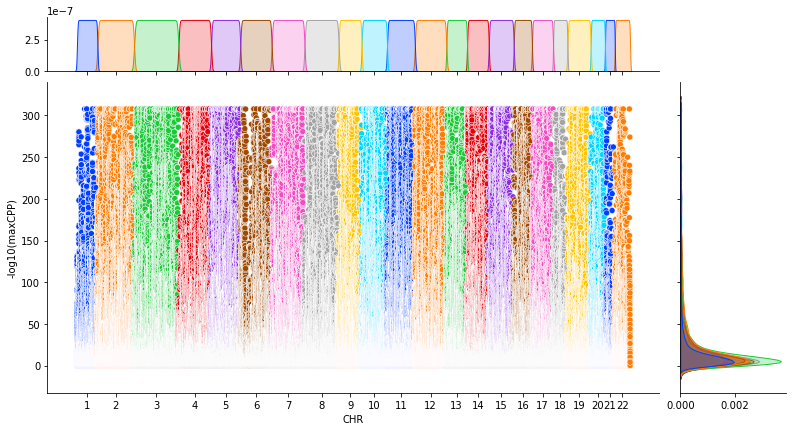

In [57]:
import seaborn as sns
to_plot = marginal_caviar[marginal_caviar['maxCPP'] != 0.0]
to_plot = to_plot.sort_values(['CHR','BP']).reset_index()
to_plot['neg_log_maxCPP'] = -1 * np.log10(to_plot['maxCPP'])
to_plot['i'] = to_plot.index
plot = sns.jointplot(
    data = to_plot,
    x = 'i', 
    y='neg_log_maxCPP',
    hue="CHR", 
    palette = "bright",
    marginal_ticks = True,
    legend = None)
chrom_df=to_plot.groupby('CHR')['i'].median()
plot.ax_joint.set_xlabel('CHR')
plot.ax_joint.set_ylabel("-log10(maxCPP)")
plot.ax_joint.set(xticks = chrom_df, xticklabels=chrom_df.index)
plot.fig.set_figwidth(12)

So it seems many non-zero causal probabilities being small (the majority are centered around $10^{-20}$ or so) and that their range is pretty huge. 

Let's load in all chromosomes and enumerate some hits:

In [7]:
import glob 
from multiprocessing import Pool
def read_path(path):
    df = pd.read_csv(path,sep='\s+')
    df['path'] = path
    return df

paths = glob.glob("../../delahaye_QC/caviar_files/marginal/**/*.out_post")
pool = Pool(32)
dfs = pool.map(read_path, paths)
pool.close()
pool.join()
marginal_caviar_all = pd.concat(dfs)
marginal_caviar_all = marginal_caviar_all[marginal_caviar_all['Causal_Post._Prob.'] != 0.0]
marginal_caviar_all["probe"] = marginal_caviar_all['path'].str.extract(r'.*/(.*).out_post')
marginal_caviar_all["CHR"] = marginal_caviar_all['path'].str.extract(r'.*/chr(.*)/.*out_post')
marginal_caviar_all = marginal_caviar_all.drop('path',axis=1)
marginal_caviar_all

,SNP_ID,Prob_in_pCausalSet,Causal_Post._Prob.,probe,CHR
0,rs186003573,1.266040e-06,2.532070e-06,cg14950855,12
1,rs78795824,7.223250e-07,1.444650e-06,cg14950855,12
2,rs7980178,7.070980e-07,1.414190e-06,cg14950855,12
3,rs147426699,5.690030e-08,1.138000e-07,cg14950855,12
4,rs564596866,5.690030e-08,1.138000e-07,cg14950855,12
...,...,...,...,...,...
106,rs9650491,9.574470e-13,1.914890e-12,cg17826006,8
107,rs34380789,5.749780e-10,1.149960e-09,cg17826006,8
108,rs4875935,5.747850e-10,1.149570e-09,cg17826006,8
109,rs112180998,9.543520e-13,1.908700e-12,cg17826006,8


In [8]:
print(f"Non-zero CPP {len(marginal_caviar_all)}\nUnique CpGs:{len(marginal_caviar_all['probe'].unique())}")

Non-zero CPP 7775879
Unique CpGs:99522


<AxesSubplot:xlabel='CHR'>

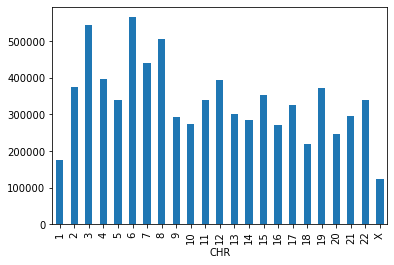

In [44]:
chr_ord = [str(i) for i in range(1,23)] + ["X"]
marginal_caviar_all.groupby("CHR").count().sort_values('CHR').reindex(chr_ord)['SNP_ID'].plot(kind='bar')

<AxesSubplot:xlabel='CHR'>

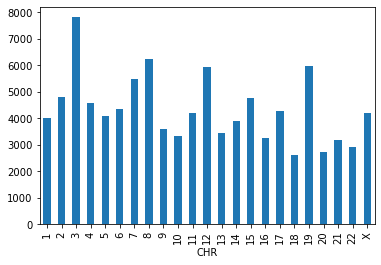

In [45]:
marginal_caviar_all.drop_duplicates(subset=['probe']).groupby("CHR").count().sort_values('CHR').reindex(chr_ord)['SNP_ID'].plot(kind='bar')

### Sex biased mQTL CAVIAR annotation

In [24]:
def read_path(path):
    df = pd.read_csv(path,sep='\s+')
    df['path'] = path
    return df

paths = glob.glob("../../delahaye_QC/caviar_files/sex_interaction/**/*.out_post")
pool = Pool(32)
dfs = pool.map(read_path, paths)
pool.close()
pool.join()
sex_caviar_all = pd.concat(dfs)
sex_caviar_all = sex_caviar_all[sex_caviar_all['Causal_Post._Prob.'] != 0.0]
sex_caviar_all["probe"] = sex_caviar_all['path'].str.extract(r'.*/(.*).out_post')
sex_caviar_all["CHR"] = sex_caviar_all['path'].str.extract(r'.*/chr(.*)/.*out_post')
sex_caviar_all = sex_caviar_all.drop('path',axis=1)
sex_caviar_all

,SNP_ID,Prob_in_pCausalSet,Causal_Post._Prob.,probe,CHR
0,rs555470528,7.146990e-13,1.429400e-12,cg15007809,12
1,rs571946166,1.488000e-11,2.975990e-11,cg15007809,12
2,rs77487825,9.329040e-16,1.865810e-15,cg15007809,12
3,rs145776511,4.922090e-16,9.844170e-16,cg15007809,12
4,rs111508514,4.694730e-16,9.389470e-16,cg15007809,12
...,...,...,...,...,...
59,rs2912075,2.344010e-12,4.688020e-12,cg07608385,8
60,rs2936514,1.387450e-12,2.774900e-12,cg07608385,8
61,rs17077852,7.778780e-16,1.555760e-15,cg07608385,8
62,rs192775349,1.587580e-15,3.175170e-15,cg07608385,8


In [25]:
print(f"Non-zero CPP {len(sex_caviar_all)}\nUnique CpGs:{len(sex_caviar_all['probe'].unique())}")

Non-zero CPP 3465338
Unique CpGs:97554


<AxesSubplot:xlabel='CHR'>

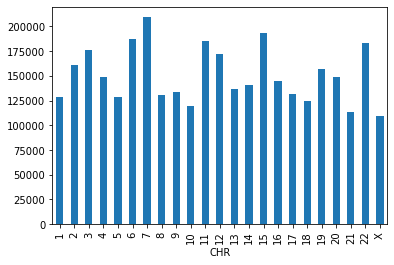

In [35]:
chr_ord = [str(i) for i in range(1,23)] + ["X"]
sex_caviar_all.groupby("CHR").count().reindex(chr_ord)['SNP_ID'].plot(kind='bar')

<AxesSubplot:xlabel='CHR'>

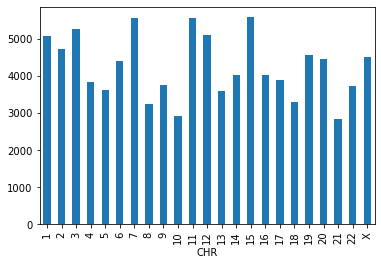

In [36]:
sex_caviar_all.drop_duplicates(subset=['probe']).groupby("CHR").count().sort_values('CHR').reindex(chr_ord)['SNP_ID'].plot(kind='bar')

## Allelic fold change differences in Males vs Females

For sex-specfic hits (at an interaction FDR < 0.05), I've further gone on to compute allelic fold change [(aFC) citation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5668944/). In the Robinson data, I've observed that females have a higher mean aFC. Here I'm going to assess the extent to which that's true in the Delahaye dataset.

0.035882235108504586
0.0


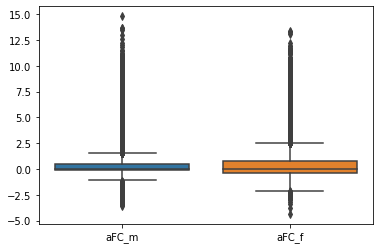

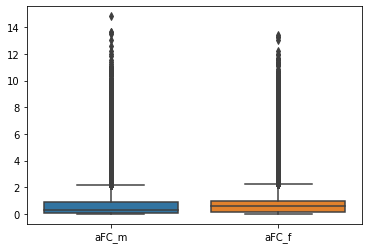

In [74]:
import seaborn as sns
from scipy import stats
snp_df = pd.read_csv("../../delahaye_QC/matrix_eqtl_data/snp_pos.txt",sep='\s+')
aFC_df = pd.read_csv("../../delahaye_QC/delahaye_stratified_regression_fdr_hits.txt", sep='\s+')
_, p_value = stats.ttest_ind(aFC_df.aFC_m, aFC_df.aFC_f,alternative='greater',equal_var=False)
print(p_value)
sns.boxplot(data=aFC_df[['aFC_m', 'aFC_f']])
_, p_value_abs = stats.ttest_ind(abs(aFC_df.aFC_m), abs(aFC_df.aFC_f),alternative='less',equal_var=False)
print(p_value_abs)
plt.figure()
sns.boxplot(data=abs(aFC_df[['aFC_m', 'aFC_f']]))

In [73]:
%%R
tmp <- read.csv("../../delahaye_QC/delahaye_stratified_regression_fdr_hits.txt",sep='\t')
print(t.test(tmp$aFC_m,tmp$aFC_f,alternative="greater"))
print(t.test(abs(tmp$aFC_m),abs(tmp$aFC_f),alternative="less"))



	Welch Two Sample t-test

data:  tmp$aFC_m and tmp$aFC_f
t = 1.8006, df = 634167, p-value = 0.03588
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.0003986258          Inf
sample estimates:
mean of x mean of y 
0.2667170 0.2621087 


	Welch Two Sample t-test

data:  abs(tmp$aFC_m) and abs(tmp$aFC_f)
t = -55.603, df = 635832, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -0.110782
sample estimates:
mean of x mean of y 
0.6047533 0.7189124 



Removing the X chromosome:

0.06409560559261232
0.0


<AxesSubplot:>

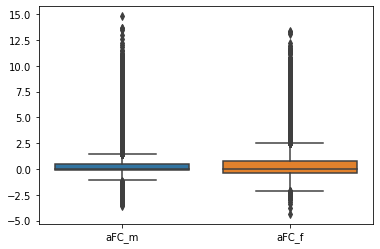

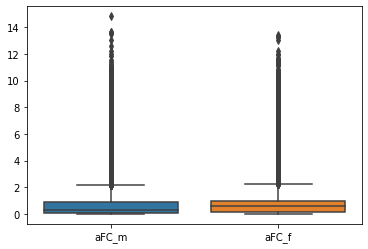

In [79]:
aFC_df_filt = aFC_df[aFC_df['SNP'].isin(snp_df[snp_df['CHR'] != "chrX"]['SNP'])]
_, p_value = stats.ttest_ind(aFC_df_filt.aFC_m, aFC_df_filt.aFC_f,alternative='less',equal_var=False)
print(p_value)
sns.boxplot(data=aFC_df_filt[['aFC_m', 'aFC_f']])
_, p_value_abs = stats.ttest_ind(abs(aFC_df_filt.aFC_m), abs(aFC_df_filt.aFC_f),alternative='less',equal_var=False)
print(p_value_abs)
plt.figure()
sns.boxplot(data=abs(aFC_df_filt[['aFC_m', 'aFC_f']]))

In [83]:
%%R -i aFC_df_filt
print(t.test(aFC_df_filt$aFC_m,aFC_df_filt$aFC_f,alternative="less"))
print(t.test(abs(aFC_df_filt$aFC_m),abs(aFC_df_filt$aFC_f),alternative="less"))


	Welch Two Sample t-test

data:  aFC_df_filt$aFC_m and aFC_df_filt$aFC_f
t = -1.5213, df = 616991, p-value = 0.0641
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
         -Inf 0.0003207705
sample estimates:
mean of x mean of y 
0.2645218 0.2684705 


	Welch Two Sample t-test

data:  abs(aFC_df_filt$aFC_m) and abs(aFC_df_filt$aFC_f)
t = -56.168, df = 618952, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.1136342
sample estimates:
mean of x mean of y 
0.6033930 0.7204553 

